# "*Winter is coming!*": A tutorial for adding sub-annual time steps to a MESSAGEix model
Seasonality or variation in demand and supply are common characteristics of an electricity system, and Westeros is not an exception. This tutorial helps to learn how to add sub-annual time steps to a MESSAGEix model and investigate the impact of these sub-annual time steps on the results. This tutorial is structured as follows:
1. A short note on seasonality
2. Adding sub-annual time steps
3. Analyzing the results

### Requirements for running this tutorial
- You have MESSAGEix framework installed and working
- You have run Westeros baseline scenario and solved it successfully

## 1. Seasonal variations in demand and supply
The electricity demand can vary in different time scales, e.g., seasonally, monthly, daily, and hourly. In Westeros, the winter time is typically cold and long, which increases the demand for electricity and lighting. We investigate this seasonality in this tutorial, but the procedure discussed here can be adopted for studying different lengths of temporal resolution.
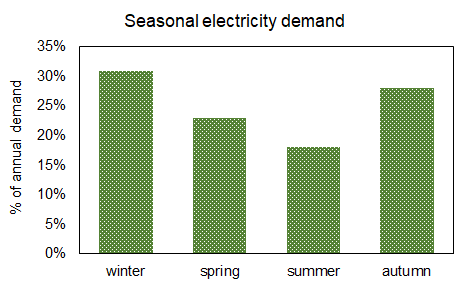

Seasonality can be relevant to some supply technologies as well. For example, Westeros has more windy days in winter months compared to summer. This means the capacity factor of a wind power plant is higher in winter compared to summer. Figure below, rendered from renewables.ninja*, shows the monthly capacity factor of wind power plant somewhere near Westeros.                                                                                                                       
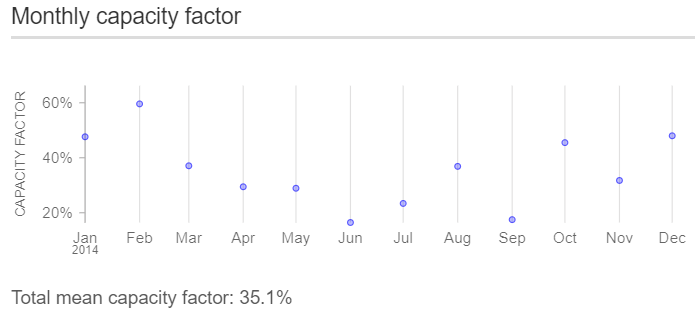

 *You can also find the capacity factor of wind and solar PV for your location at www.renewables.ninja, as we found for a place near Westeros.

## 2. Implementation of seasonality
In this tutorial we add two sub-annual time steps, winter and summer. First, we load the baseline scenario, then we add the required sets related to seasonality, next we modify the parameters, and finally we analyze the results.

### 2.1. Loading Westeros baseline scenario 

In [ ]:
# Importing required packages
import pandas as pd
import ixmp as ix
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [ ]:
# Loading modelling platform
mp = ix.Platform(dbtype='HSQLDB')

In [ ]:
# Specifying model/scenario to be loaded from the database
model = 'Westeros Electrified'
scenario='baseline'
base = message_ix.Scenario(mp, model, scenario)

# Cloning a scenario for adding time steps
scen = base.clone(model, 'westeros_seasonal','introducing seasonality', keep_solution=False)
scen.check_out()

### 2.2 Modifying sets
First, we specify subannual time steps and add them to relevant MESSAGE sets. In the MESSAGEix framework set "time" is devoted for sub-annual time steps, denoted as index *h* in the mathematical formulation:

| Set name | Math notation | Explanation |
|----------|---------------|----------------------------------------------|
| time     | $h \in H$     | subannual time periods |

In [ ]:
# Adding sub-annual time steps
time_steps = ['winter', 'summer']
scen.add_set('time', time_steps)

In [ ]:
# We can see the elements of the set
scen.set('time')

In [ ]:
# Defining a new temporal level
scen.check_out()
time_level = 'season'
scen.add_set('lvl_temporal', time_level)

Next, the temporal hierarchy will be defined to map different levels of time with respect to "year", which is the parent temporal level for any "time". 

In [ ]:
# Adding temporal hierarchy
for t in time_steps:
    scen.add_set('map_temporal_hierarchy', [time_level, t, 'year'])
    
# We can see the content of the set
scen.set('map_temporal_hierarchy')

### 2.3. Modifying parameters
In this Section, we modify some parameters based on the new time steps. In principle, we need to examine all parameters that have an index of "time" to see if we need to modify them or not.

In [ ]:
# All parameters with at least one sub-annual time index
parameters = [p for p in scen.par_list() if 'time' in scen.idx_sets(p)]

# Those parameters with "time" index that are not empty in our model
[p for p in parameters if not scen.par(p).empty]

### Parameter "duration_time"
We start by modifying the parameter "duration_time", which shows the length of each subannual time step relative to the whole year:

| Parameter | Index set| Explanation|
|-----------|----------| -----------|
| duration_time	| time	|duration of sub-annual time slices (relative to 1)| 

In our example, winter and summer are each half of the year.

In [ ]:
# Adding duration time
for t in time_steps:
    scen.add_par('duration_time', [t], 0.5, '-')

### A function for modifying parameters
In this stage, we introduce a function that helps us to modify the parameters after adding new time steps. This function called "yearly_to_season" does the following:
- removing old values, where the "time" index was "year"
- populating data for new "time" indexes
- using the ratios defined by the user to convert yearly values to seasonal ones

In [ ]:
# A function for adding sub-annual data to a parameter
def yearly_to_season(scen, parameter, data, filters=None):
    if filters:
        old = scen.par(parameter, filters)
    else:
        old = scen.par(parameter)
    scen.remove_par(parameter, old)
    
    # Finding "time" related indexes
    time_idx = [x for x in scen.idx_names(parameter) if 'time' in x]
    for h in data.keys():
        new = old.copy()
        for time in time_idx:
            new[time] = h
        new['value'] = data[h] * old['value']
        scen.add_par(parameter, new)

### Modifying electricity demand in sub-annual time steps
The seasonality in demand for electricity and lighting can be taken into account by estimating different values for each time step. For example, the share of electricity demand in winter and summer in Westeros is approximately 0.6 and 0.4 of the yearly demand. We can get the yearly demand from baseline scenario and divide it to the two seasons according to their shares.

In [ ]:
# Before modifying, let's look at "demand" in baseline
scen.par('demand')

In [ ]:
# Modifying demand for each season
demand_data = {'winter': 0.60, 'summer': 0.40}
yearly_to_season(scen, 'demand', demand_data)

# let's look at "demand" now
scen.par('demand')

### Modifying "input" and "output"
However, not all parameters that have subannual time steps need to divide their values for each time step. For example, "output" parameter shows the output efficiency, commodities and level of a technology. Hence, as far as the efficiency of a technology remains unchanged in different seasons, the value of "output" remains fixed. As such, we only need to add the sub-annual time steps but with the same value as for the yearly one.

In [ ]:
# Modifying input and output parameters for each season
# output
fixed_data = {'winter': 1, 'summer': 1}
yearly_to_season(scen, 'output', fixed_data)

# input
yearly_to_season(scen, 'input', fixed_data)

### Modifying dynamic constraints
Next, we modify dynamic constraints with a "time" index, i.e. growth and decline rates of activities. In the Westeros baseline scenario, there is only growth_activity_up, so this parameter will be modified for seasonality but with the same values. 

In [ ]:
# Modifying growth rates for each season
yearly_to_season(scen, 'growth_activity_up', fixed_data)

### Modifying capacity factor
We discussed about the variation in the capacity factor of wind power in each month. By averaging the values for the respective months, we reach a capacity factor of 0.46 for winter and 0.25 for summer in Westeros. For simplicity, the capacity factor of wind was 1 in the baseline scenario.


In [ ]:
# Modifying capacity factor
# Retrieving average yearly capacity factor of wind in the model
cf_wind = scen.par('capacity_factor', {'technology':'wind_ppl'})['value'].mean()

# Passing seasonal capacity factors as shares of the yearly value
cf_data = {'winter': 0.46/cf_wind, 'summer': 0.25/cf_wind} 
cf_filters = {'technology': 'wind_ppl'}
yearly_to_season(scen, 'capacity_factor', cf_data, cf_filters)

# Capacity factor of other technologies remains unchanged in each season
cf_filters = {'technology': ['coal_ppl', 'bulb', 'grid']}
yearly_to_season(scen, 'capacity_factor', fixed_data, cf_filters)

# Let's look at capacity factor in year 710
scen.par('capacity_factor', {'year_act':710, 'year_vtg':710})

### Modifying historical activity
"historical_activity" is one of the parameters that the data should be divided between the seasons. In the absence of recorded data in Westeros before 690, we assume historical values can be divided by half for each season:

In [ ]:
# Modifying historical activity 
hist_data = {'winter': 0.5, 'summer': 0.5}
yearly_to_season(scen, 'historical_activity', hist_data)

### Economic parameters
Investment cost is defined per installed capacity per year and it is not related to subannual time steps, so it remains unchanged. Variable cost is time-dependent so the "time" index should be updated. However, as variable cost is defined per unit of activity, the "value" can remain unchanged for different time steps.

In [ ]:
# Modifying variable cost
yearly_to_season(scen, 'var_cost', fixed_data)

### 2.4. Solving the model

In [ ]:
scen.commit(comment='introducing seasonality')
scen.set_as_default()

In [ ]:
scen.solve()

In [ ]:
scen.var('OBJ')['lvl']

## 3. Postprocessing and analyzing results
### 3.1. Plotting results

In [ ]:
from tools import Plots
p = Plots(scen, country='Westeros', firstyear=700)

### Activity

How much energy is generated in each time period from the different potential sources?

In [ ]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Installed capacity

Given how many new plants are built, how many are actually used?

In [ ]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

### Electricity Price

Electricity prices are **dual variables** of the optimization solution called **shadow prices** as well. They reflect the marginal cost of producing one more unit of electricity, hence, representing the marginal cost of the most expensive generator in the system.  

In [ ]:
p.plot_prices(subset=['light'], baseyear=True)

### 3.2. Questions and discussion
1. Compare the objective value of this scenario with the baseline; which power system is more costly? Given the fact that electricity demand and the cost of technologies are equal between these two scenarios, how do you justify the change in the total costs?

2. Compare the figure for "Activity" between this scenario and the baseline; do you observe any changes in the energy mix? The results show more wind integration in this scenario. What is the reason?
 
3. If you check out the figure for "Capacity" in both scenarios, you'll notice that the increase in the installed capacity of wind is much higher than the growth in wind generation. Can you explain the reason?

4. Rerun this tutorial for a scenario with 4 sub-annual time steps: winter, spring, summer and autumn (each one-forth of the whole year)



### *Discussion*: 
The greater avilability of wind in wintertime coincides with the higher demand for electricity in winter compared to summer. Hence, when coal power plants are not able to cover the increased electricity demand in winter, the system needs more wind generation compared to the baseline (for example, see the results for "Activity" in 700):

In [ ]:
scen.var('ACT', {'year_act': 700})

Adding seasonality to the model shows the impact of this matching between wind and electricity demand on the results, which can be averaged out if the yearly demand is taken into account. The capacity factor of wind is near actual values in this scenario (0.46 in winter and 0.25 in summer), while it is 1 in the baseline scenario. Therefore, we observe relatively much higher installed capacity compared to the baseline, and as such a more expensive system. 

### Final note

Thank you for trying this tutorial!

Check us out on Github: https://github.com/iiasa/message_ix  

Get in touch with us online: https://groups.google.com/forum/message-ix  

And feel free to contact us with any further questions or feedback for improving this tutorial: zakeri@iiasa.ac.at

In [ ]:
mp.close_db()